## **Compose**

## **Params**

In [1]:
from pathlib import Path
from typing import Iterable, Sequence

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

SAFE_SAMPLES_DIR = Path("outputs/safe_samples")

In [2]:
#temporarily silence swapaxds warning

import warnings
warnings.filterwarnings(
    "ignore",
    message=".*DataFrame.swapaxes.*",
    category=FutureWarning
)

In [3]:
plt.rcParams['grid.color'] = [0.8, 0.8, 1.0, 0.5]
plt.rcParams['axes.edgecolor'] = [0.2, 0.2, 0.5, 0]
plt.rcParams['font.family'] = 'monospace'

In [18]:
def _resolve_paths(entries: Iterable[Path | str]) -> list[Path]:
    normalized: list[Path] = []
    for entry in entries:
        path = Path(entry)
        if not path.exists():
            candidate = None
            if not path.is_absolute():
                # Try relative to the safe samples directory first
                candidate = SAFE_SAMPLES_DIR / path
                if not candidate.exists() and path.name != str(path):
                    fallback = SAFE_SAMPLES_DIR / path.name
                    if fallback.exists():
                        candidate = fallback
                if candidate and candidate.exists():
                    path = candidate
                else:
                    raise FileNotFoundError(f"CSV path not found: {entry}")
            else:
                raise FileNotFoundError(f"CSV path not found: {entry}")
        normalized.append(path)
    return normalized


def _resolve_csv_args(csv_args: tuple) -> list[Path]:
    if not csv_args:
        return sorted(SAFE_SAMPLES_DIR.glob("*.csv"))
    if len(csv_args) == 1 and isinstance(csv_args[0], Iterable) and not isinstance(csv_args[0], (str, bytes, Path)):
        entries = list(csv_args[0])
    else:
        entries = list(csv_args)
    if not entries:
        return []
    return _resolve_paths(entries)


def predict_composition(
    *csv_paths: Path | str | Iterable[Path | str],
    bristle_z_cutoff: float = -18.0,
    canvas_bounds: Sequence[Sequence[float]] | None = None,
    figsize: tuple[float, float] = (10.0, 10.0),
    rotate_cw90: bool = False,
) -> tuple[plt.Figure, plt.Axes]:
    """Plot 2D XY trajectories for one or many safe CSV paths.

    Parameters
    ----------
    csv_paths : Path | str | Iterable
        One or more CSV paths. If omitted, all CSV files in ``SAFE_SAMPLES_DIR``
        are used. Passing a single iterable (e.g. list) is also supported.
        Windows users should prefer raw strings (``r'C\\path'``) or forward
        slashes when supplying absolute paths.
    bristle_z_cutoff : float, optional
        Z threshold (mm) that separates in-contact segments (<= cutoff, blue)
        from travel segments (> cutoff, grey). Defaults to -18.0 mm.
    canvas_bounds : Sequence[Sequence[float]], optional
        Rectangle describing the canvas region. Provide two opposite corners as
        ``((x_min, y_min, z), (x_max, y_max, z))`` or any iterable with at least
        four XY coordinates. Only the XY components are used for the overlay.
        If omitted, no canvas outline is drawn.
    figsize : tuple, optional
        Size of the Matplotlib figure.
    rotate_cw90 : bool, optional
        Rotate all XY coordinates 90 degrees clockwise about the origin before
        plotting. Defaults to ``False``.

    Returns
    -------
    (Figure, Axes)
        The Matplotlib figure and axes objects for further customization.
    """
    paths = _resolve_csv_args(csv_paths)
    if not paths:
        raise ValueError("No CSV trajectories provided or found in outputs/safe_samples.")

    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title("Predicted Composition (XY View)")

    if rotate_cw90:
        ax.set_xlabel("Y (mm) [rotated 90deg CW]")
        ax.set_ylabel("-X (mm) [rotated 90deg CW]")
    else:
        ax.set_xlabel("X (mm)")
        ax.set_ylabel("Y (mm)")
    ax.set_aspect("equal", adjustable="box")

    rect = None
    if canvas_bounds is not None:
        if len(canvas_bounds) < 2:
            raise ValueError("canvas_bounds must contain at least two corner coordinates.")
        try:
            rotated_corners = []
            for corner in canvas_bounds:
                x_val, y_val = corner[0], corner[1]
                if rotate_cw90:
                    x_val, y_val = y_val, -x_val
                rotated_corners.append((x_val, y_val))
        except (TypeError, IndexError) as exc:
            raise ValueError("canvas_bounds entries must be iterable XYZ coordinates.") from exc
        xs = [pt[0] for pt in rotated_corners]
        ys = [pt[1] for pt in rotated_corners]
        min_x, max_x = min(xs), max(xs)
        min_y, max_y = min(ys), max(ys)
        rect = Rectangle(
            (min_x, min_y),
            width=max_x - min_x,
            height=max_y - min_y,
            facecolor="none",
            edgecolor="black",
            linewidth=1.5,
            linestyle="--",
            label="Canvas boundary",
        )
        ax.add_patch(rect)

    for path in paths:
        df = pd.read_csv(path)
        missing = {"X_mm", "Y_mm", "Z_mm"}.difference(df.columns)
        if missing:
            raise ValueError(f"{path} missing required columns: {sorted(missing)}")

        mask = df["Z_mm"].to_numpy() <= bristle_z_cutoff
        change_idx = np.where(mask[1:] != mask[:-1])[0] + 1
        segments = np.split(df, change_idx)
        mask_segments = np.split(mask, change_idx)

        for seg, seg_mask in zip(segments, mask_segments):
            if seg.empty:
                continue
            color = "#1f77b4" if seg_mask[0] else "0.6"
            x_vals = seg["X_mm"].to_numpy()
            y_vals = seg["Y_mm"].to_numpy()
            if rotate_cw90:
                x_vals, y_vals = y_vals, -x_vals
            ax.plot(x_vals, y_vals, color=color, linewidth=1.5, alpha=0.9)

    legend_elements = [
        plt.Line2D([0], [0], color="#1f77b4", lw=2, label=f"Z <= {bristle_z_cutoff} mm"),
        plt.Line2D([0], [0], color="0.6", lw=2, label=f"Z > {bristle_z_cutoff} mm"),
    ]
    if rect is not None:
        legend_elements.append(
            plt.Line2D([0], [0], color="black", lw=1.5, linestyle="--", label="Canvas boundary")
        )
    ax.legend(handles=legend_elements, loc="best")
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig, ax



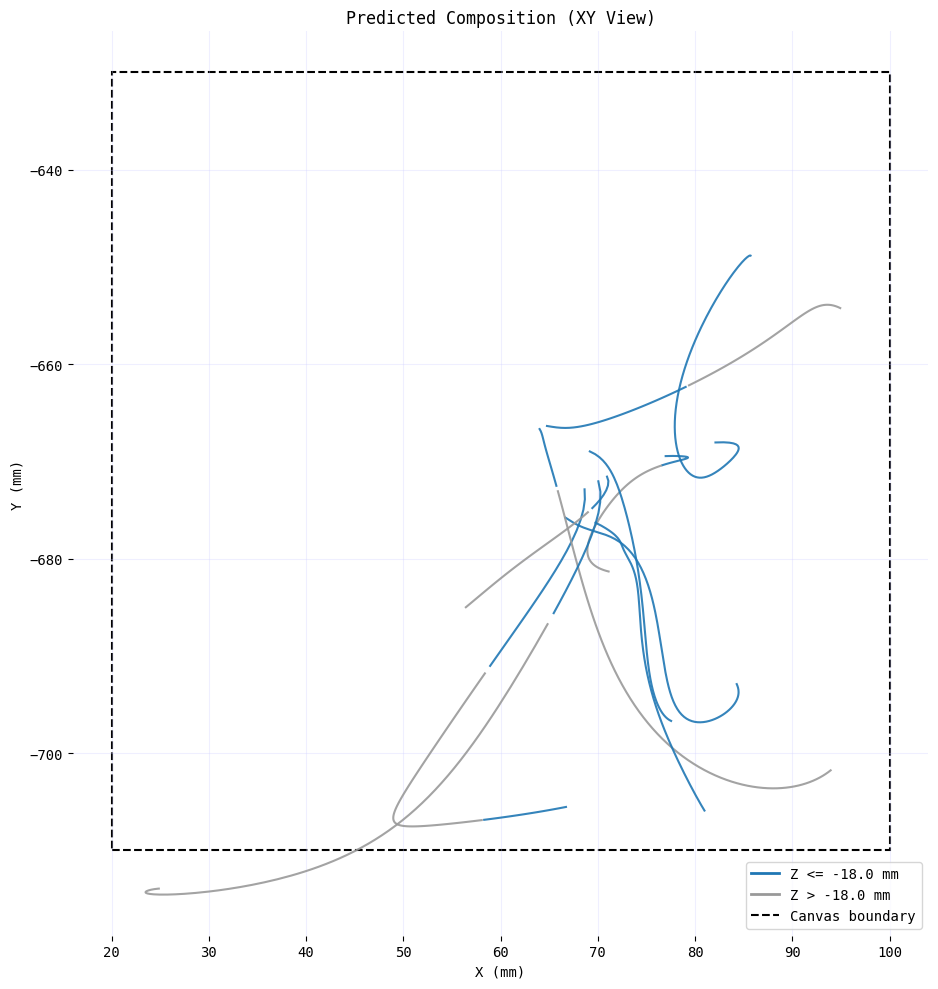

In [23]:
# dont input csv paths to run all detected in the folder
fig, ax = predict_composition(canvas_bounds=[(20, -710, 0), (100, -630, 0)])


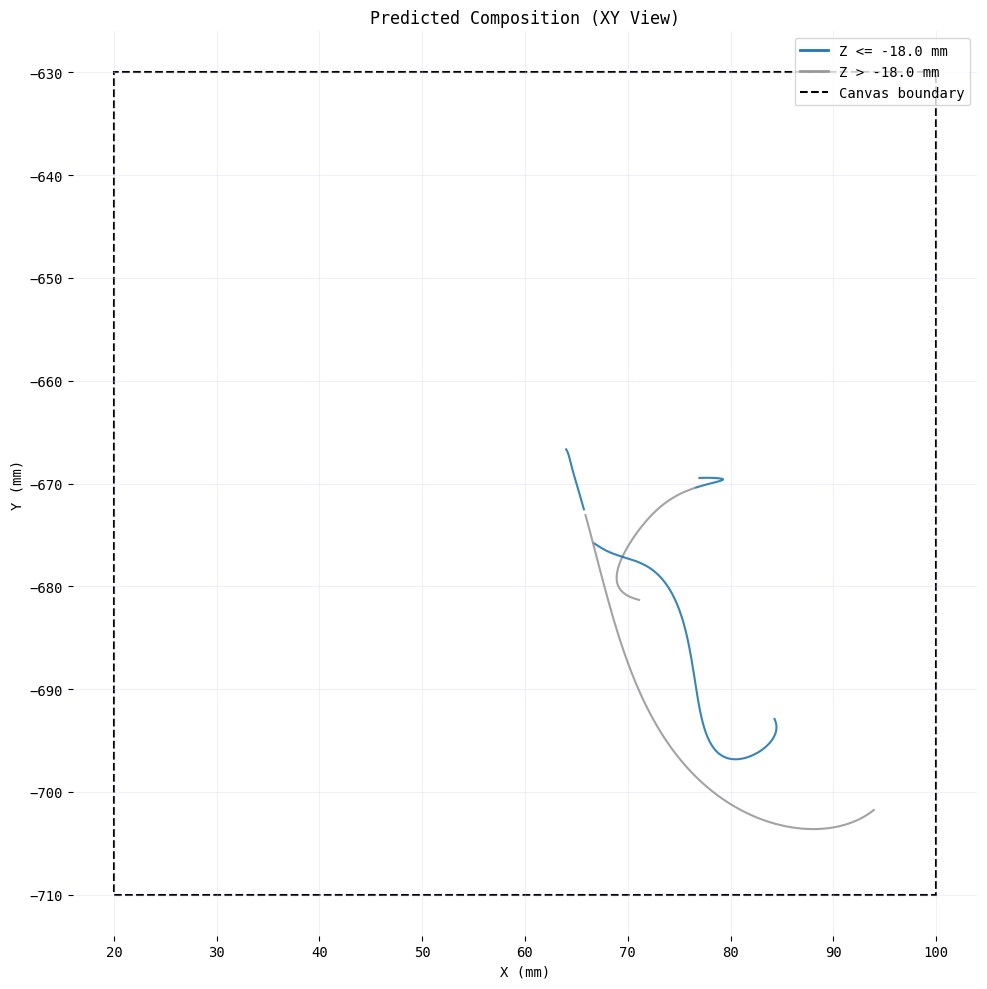

In [24]:
# can also specify which csvs

fig, ax = predict_composition(
    ["brushstroke_sample_20251028_145333_0_zsafe.csv",
     "brushstroke_sample_20251028_145333_1_zsafe.csv",
     "brushstroke_sample_20251028_145333_4_zsafe.csv"], 
    canvas_bounds=[(20, -710, 0), (100, -630, 0)])